In [62]:
# Importaciones estándar
import os
import random

# Importaciones de terceros
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import ToPILImage
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
import argparse
import pandas as pd

data = pd.read_csv('data_temp_cleaned.csv')

OSError: [WinError 126] No se puede encontrar el módulo especificado. Error loading "c:\Users\nicoi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [63]:
data

index                      video  idx_frame  confidence  box_id  \
0          1  20180813_FIRE_bl-n-mobo-c          1    0.024375       1   
1          5  20180813_FIRE_bl-n-mobo-c          5    0.059832       1   
2          7  20180813_FIRE_bl-n-mobo-c          5    0.010395       3   
3          8  20180813_FIRE_bl-n-mobo-c          6    0.024893       1   
4          9  20180813_FIRE_bl-n-mobo-c          6    0.017090       2   
...      ...                        ...        ...         ...     ...   
34299  90571      pyronear_marguerite_4        249    0.067213       4   
34300  90573      pyronear_marguerite_4        250    0.178369       1   
34301  90576      pyronear_marguerite_4        251    0.337191       1   
34302  90579      pyronear_marguerite_4        252    0.427592       1   
34303  90581      pyronear_marguerite_4        253    0.157016       1   

            iou  t_0  t_1  t_2  t_3  t_4  \
0      0.000000    0    0    0    0    0   
1      0.000000    0    0    0    0    0   
2      0.000000    0    0    0    0    0   
3      0.000000    0    0    0    0    0   
4      0.000000    0    0    0    0    0   
...         ...  ...  ...  ...  ...  ...   
34299  0.000000    0    0    0    0    0   
34300  0.386552    1    1    1    1    1   
34301  0.312011    1    1    1    1    1   
34302  0.147954    0    0    0    1    1   
34303  0.339866    1    1    1    1    1   

                                                     box  \
0      [0.10080795735120773, 0.49712076783180237, 0.1...   
1      [0.09792917221784592, 0.497580885887146, 0.125...   
2      [0.529897153377533, 0.5024097561836243, 0.5524...   
3      [0.10207326710224152, 0.4980655610561371, 0.12...   
4      [0.5297262072563171, 0.502344012260437, 0.5546...   
...                                                  ...   
34299  [0.6064764261245728, 0.5096747875213623, 0.624...   
34300  [0.306871622800827, 0.48085176944732666, 0.322...   
34301  [0.30487847328186035, 0.4738115668296814, 0.32...   
34302  [0.2958960235118866, 0.46072813868522644, 0.32...   
34303  [0.31109943985939026, 0.4761364459991455, 0.33...   

                                                   frame  
0      hpwren_figlib_blnmobocX01000_2018_08_13T23_14_...  
1      hpwren_figlib_blnmobocX01000_2018_08_13T23_18_...  
2      hpwren_figlib_blnmobocX01000_2018_08_13T23_18_...  
3      hpwren_figlib_blnmobocX01000_2018_08_13T23_19_...  
4      hpwren_figlib_blnmobocX01000_2018_08_13T23_19_...  
...                                                  ...  
34299      pyronear_marguerite_4_2023_11_07T12_15_40.jpg  
34300      pyronear_marguerite_4_2023_11_07T12_16_09.jpg  
34301      pyronear_marguerite_4_2023_11_07T12_16_38.jpg  
34302      pyronear_marguerite_4_2023_11_07T12_17_08.jpg  
34303      pyronear_marguerite_4_2023_11_07T12_20_39.jpg  

[34304 rows x 13 columns]

In [38]:
dataset_path = "D:/dataincendios\data\datav3/train/"

In [ ]:
def make_square_chop(y1, y2, x1, x2, img_height=640, img_width=640, growth_factor=1.1):
    center_y = (y1 + y2) / 2
    center_x = (x1 + x2) / 2
    half_size = max((y2 - y1), (x2 - x1)) / 2 * growth_factor

    half_size = min(half_size, center_y, img_height - center_y, center_x, img_width - center_x)
    new_y1 = max(0, int(center_y - half_size))
    new_y2 = min(img_height, int(center_y + half_size))
    new_x1 = max(0, int(center_x - half_size))
    new_x2 = min(img_width, int(center_x + half_size))

    return new_y1, new_y2, new_x1, new_x2

20180813_FIRE_bl-n-mobo-c


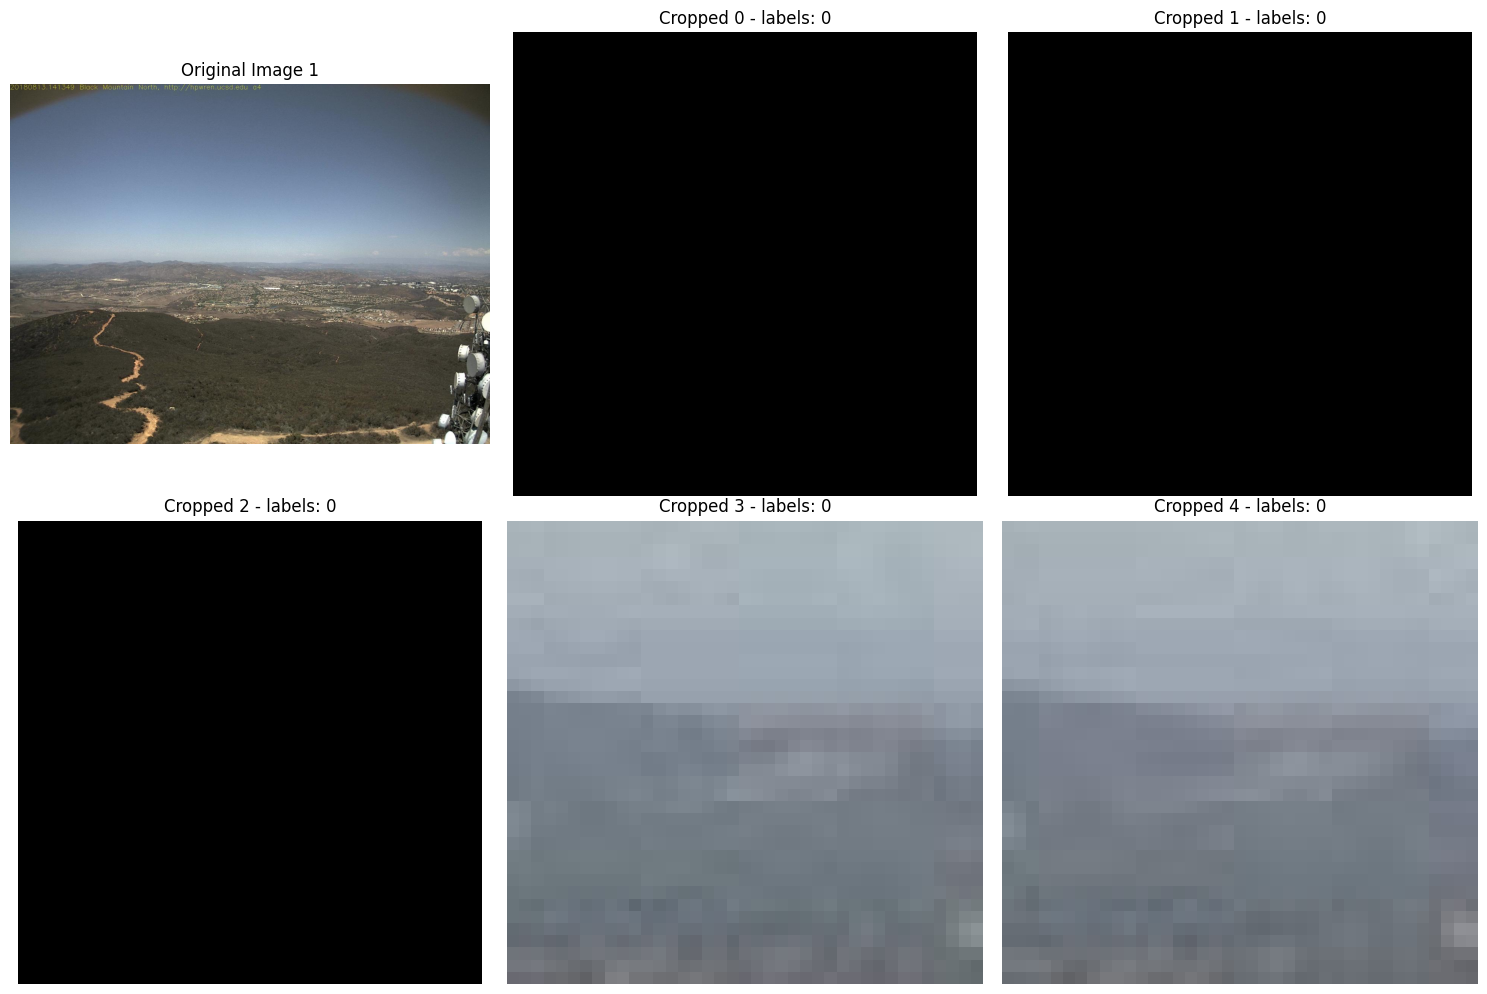

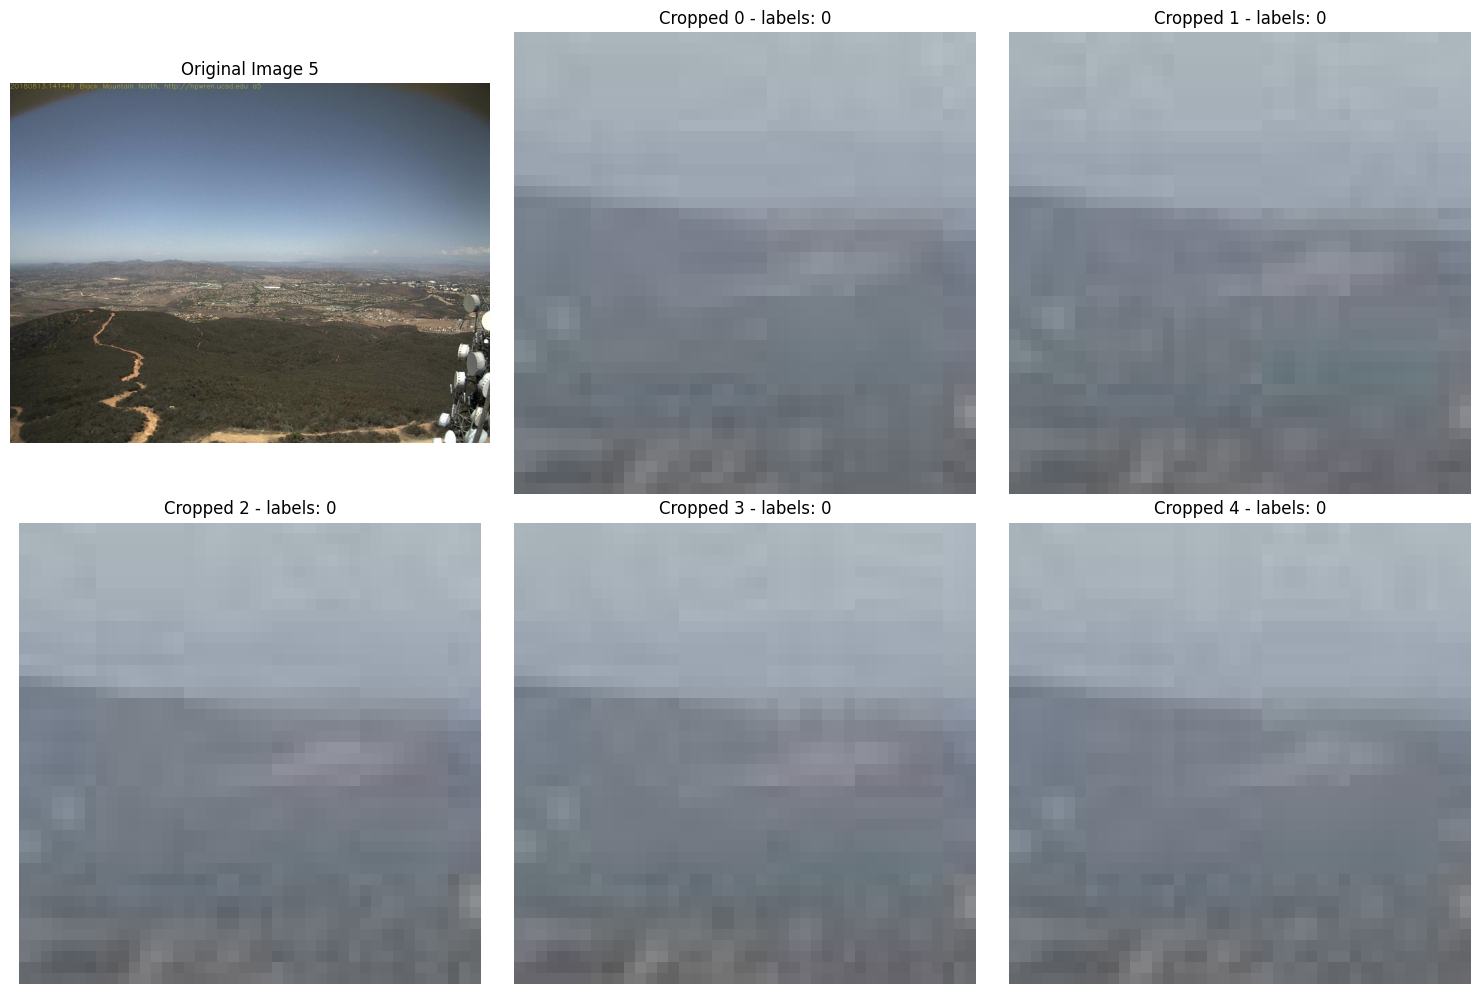

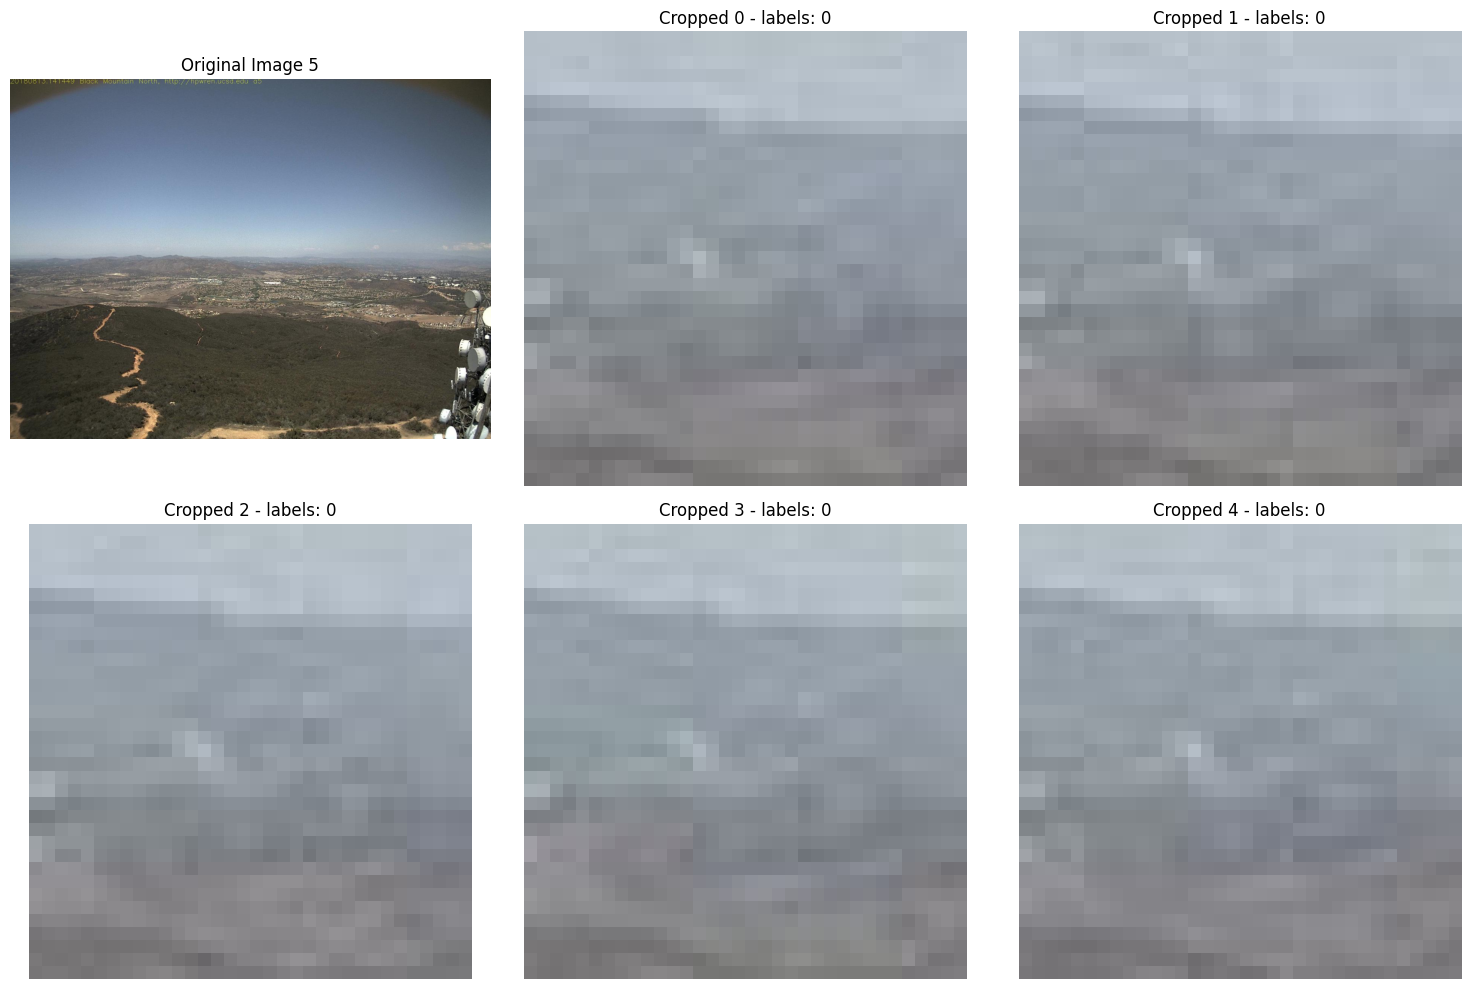

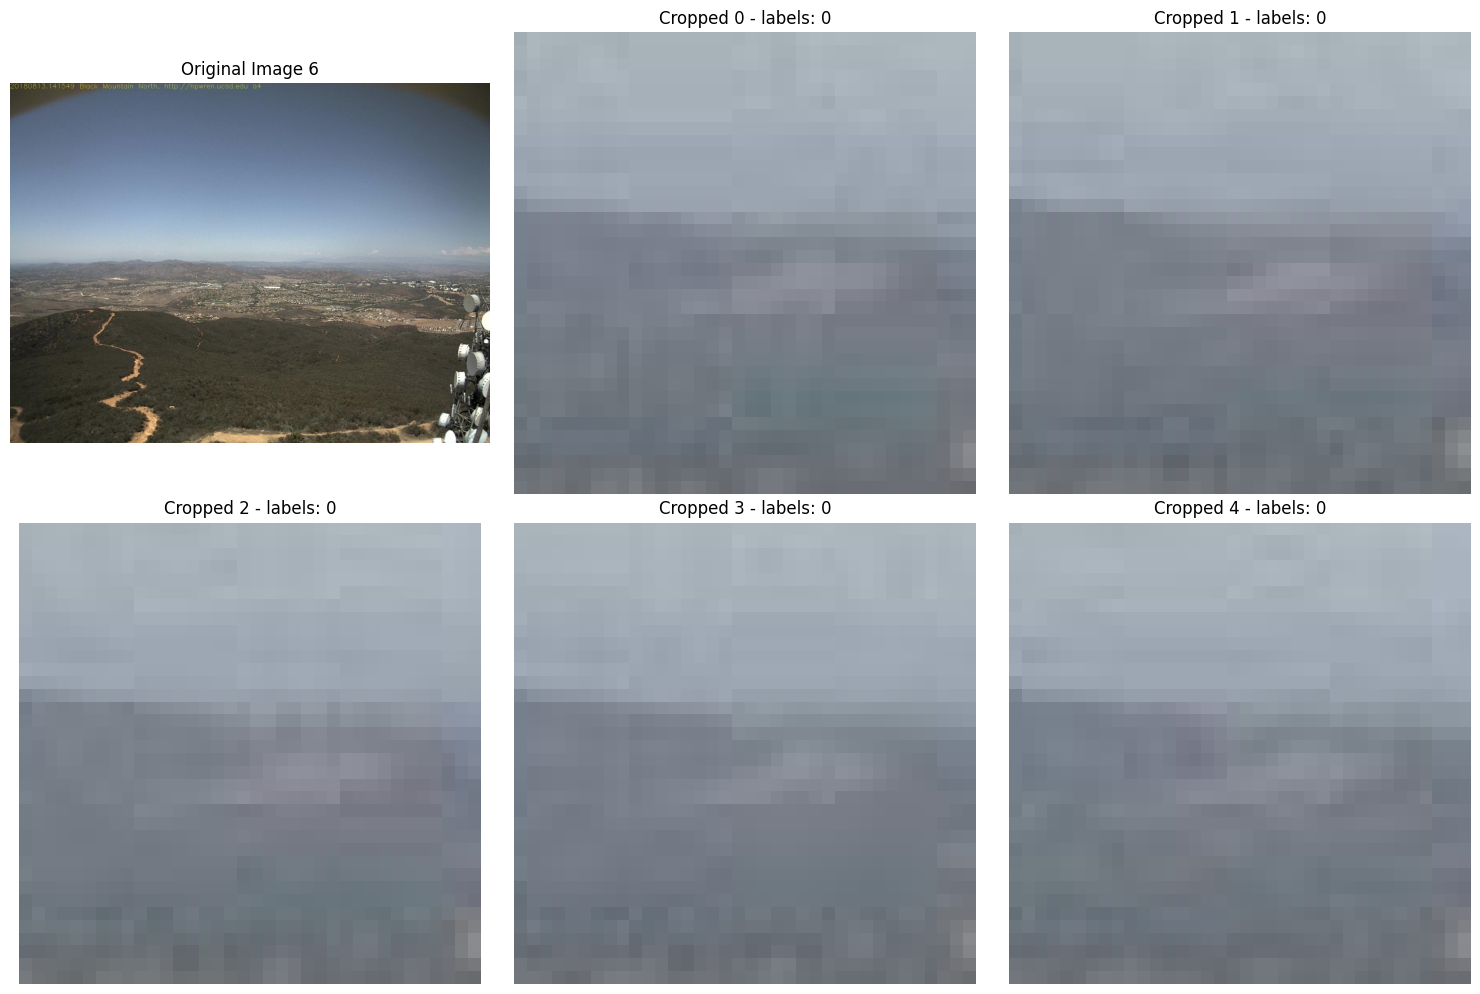

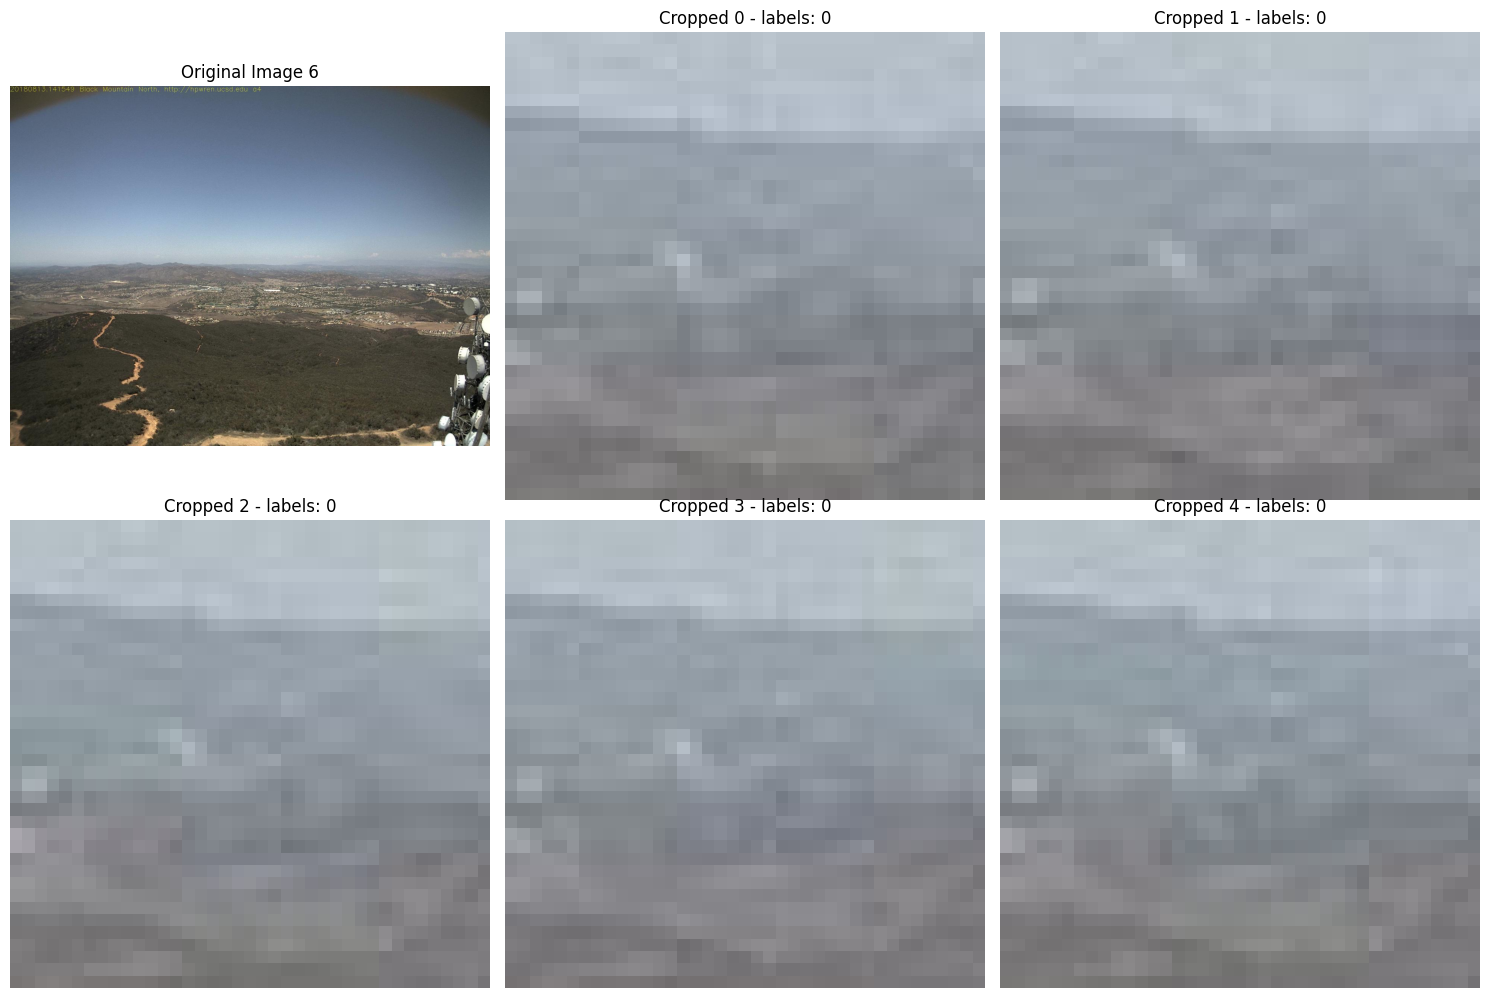

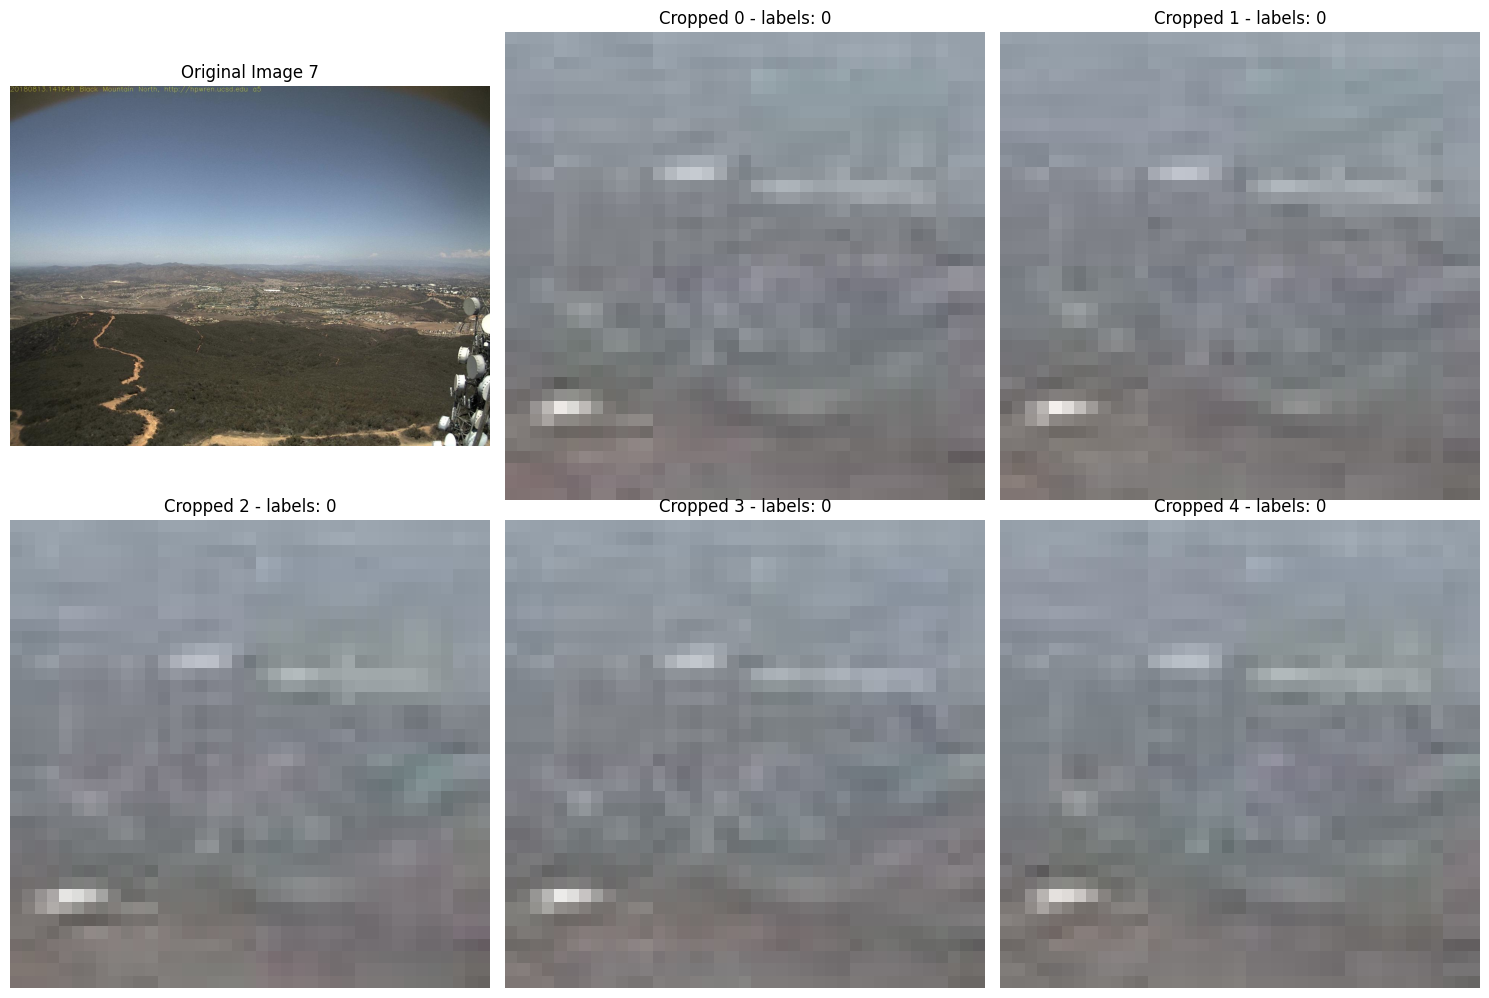

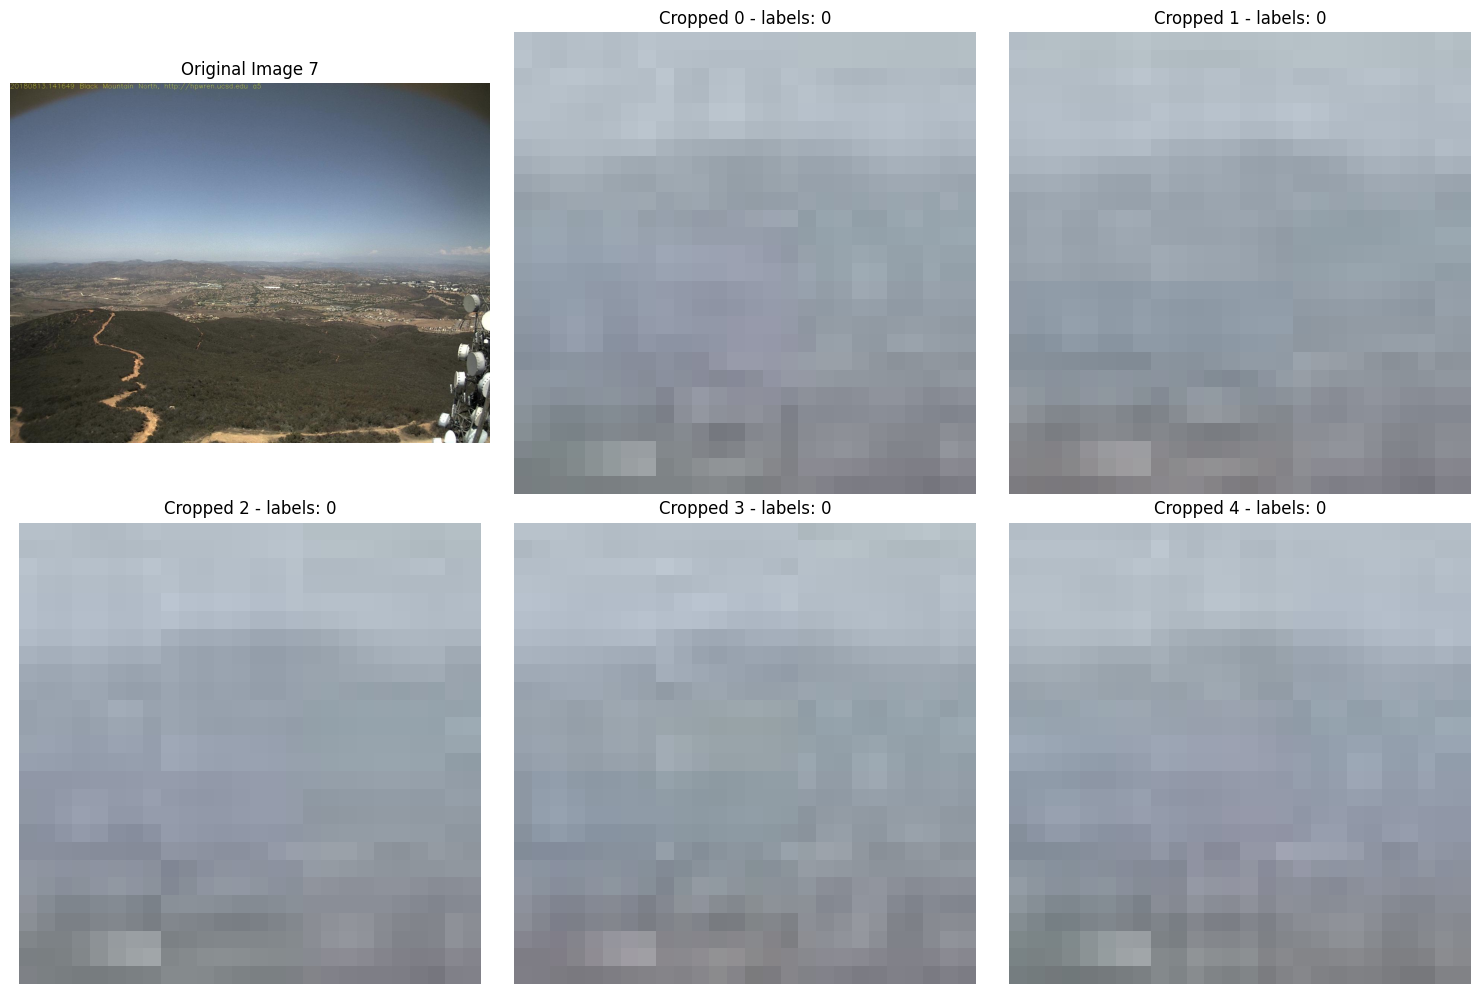

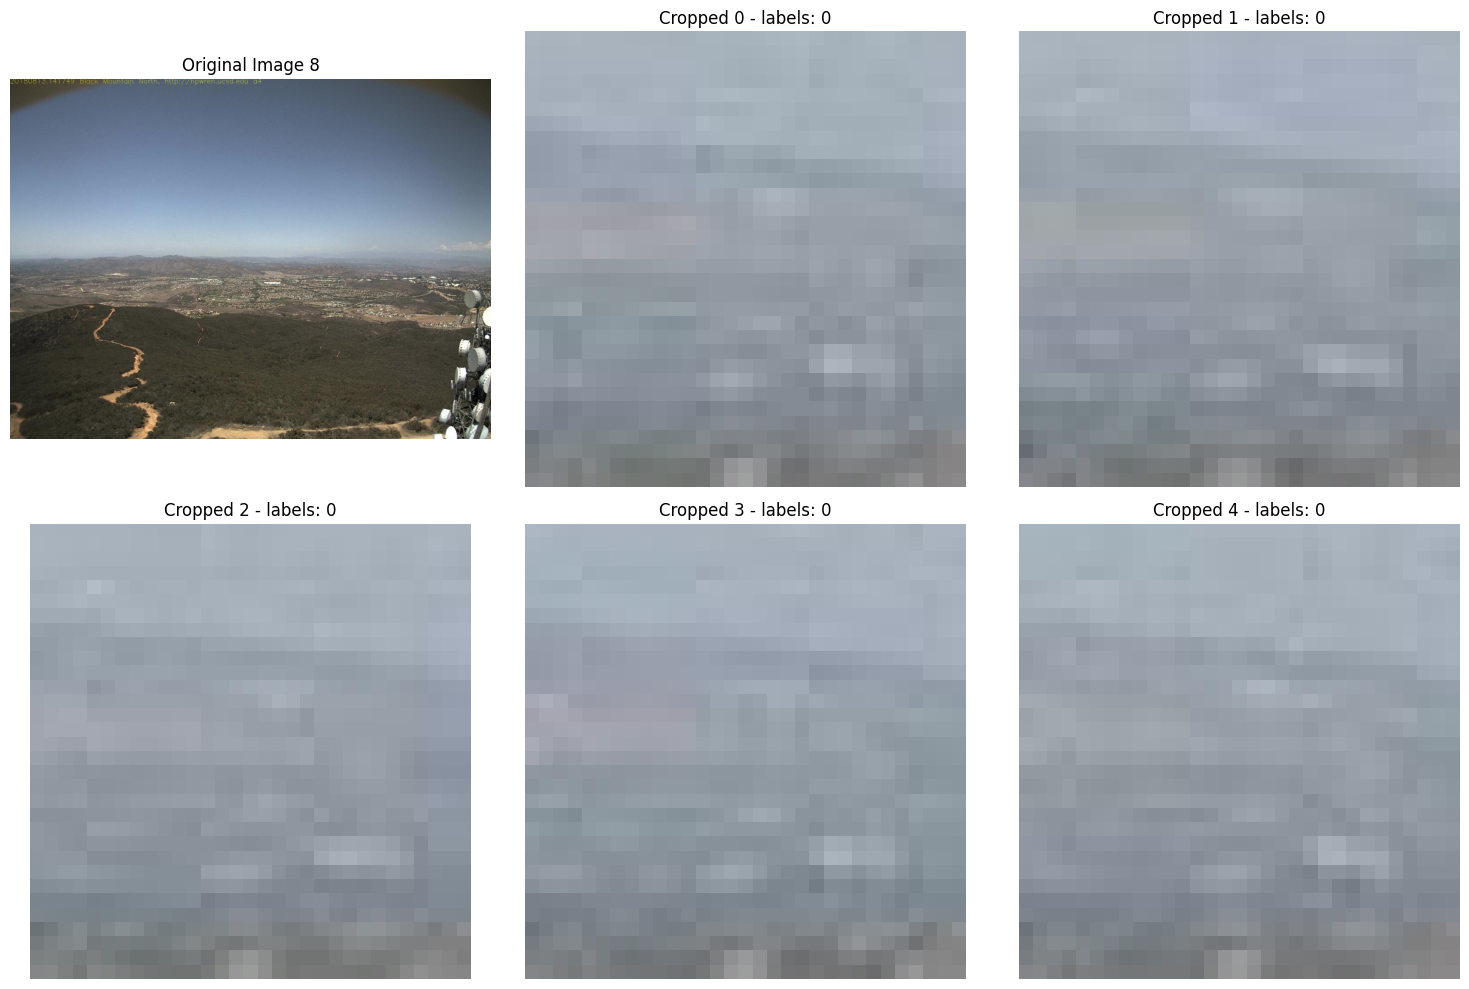

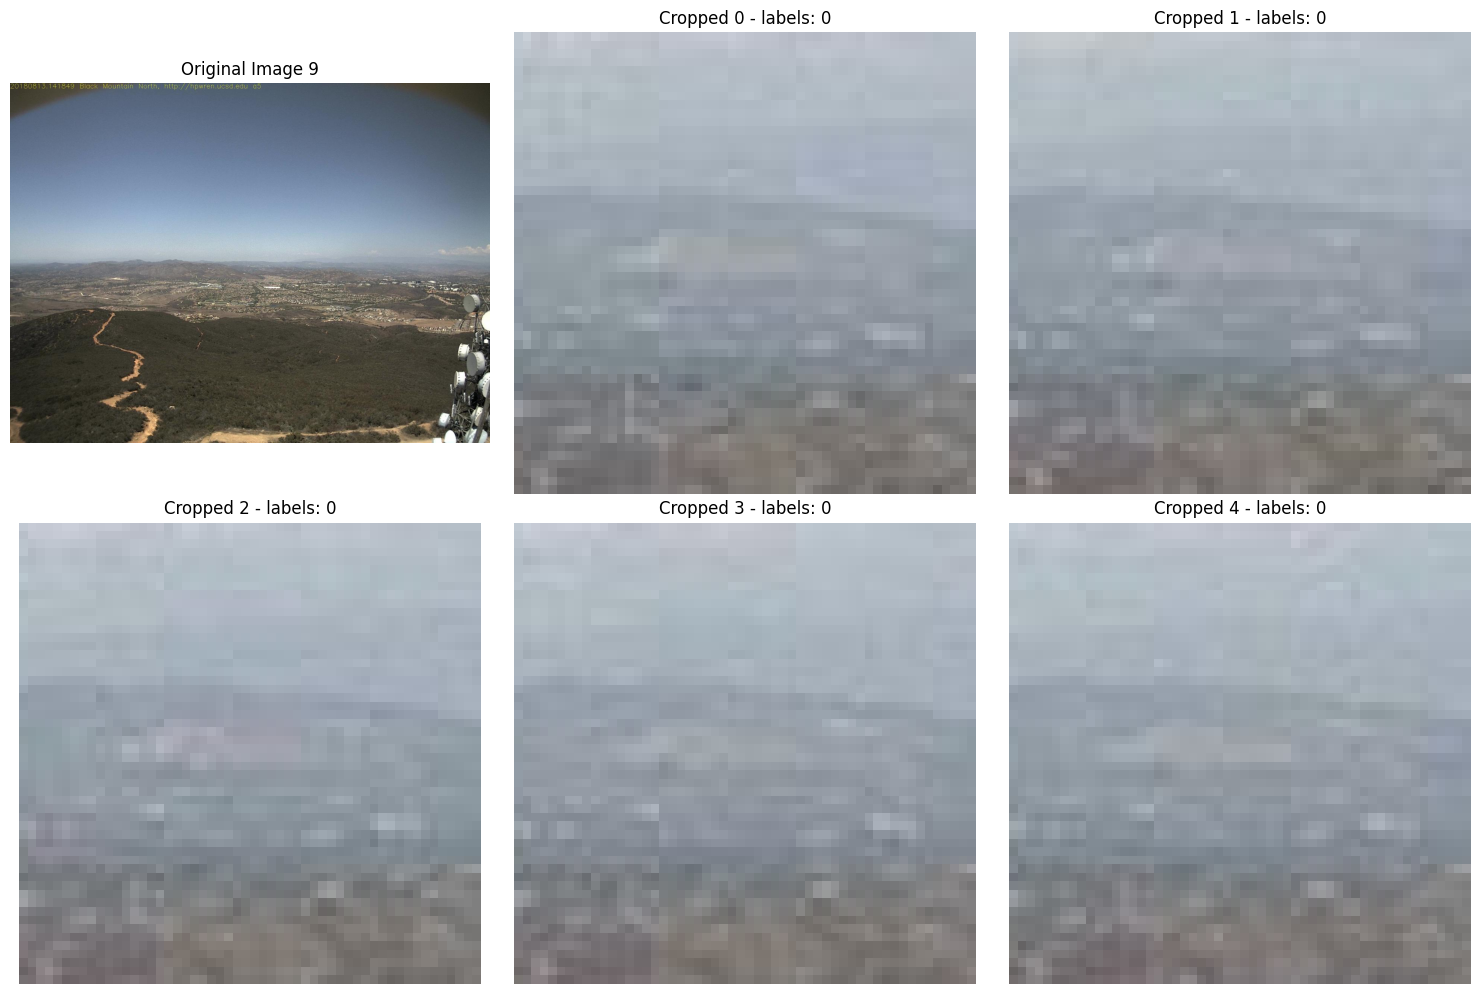

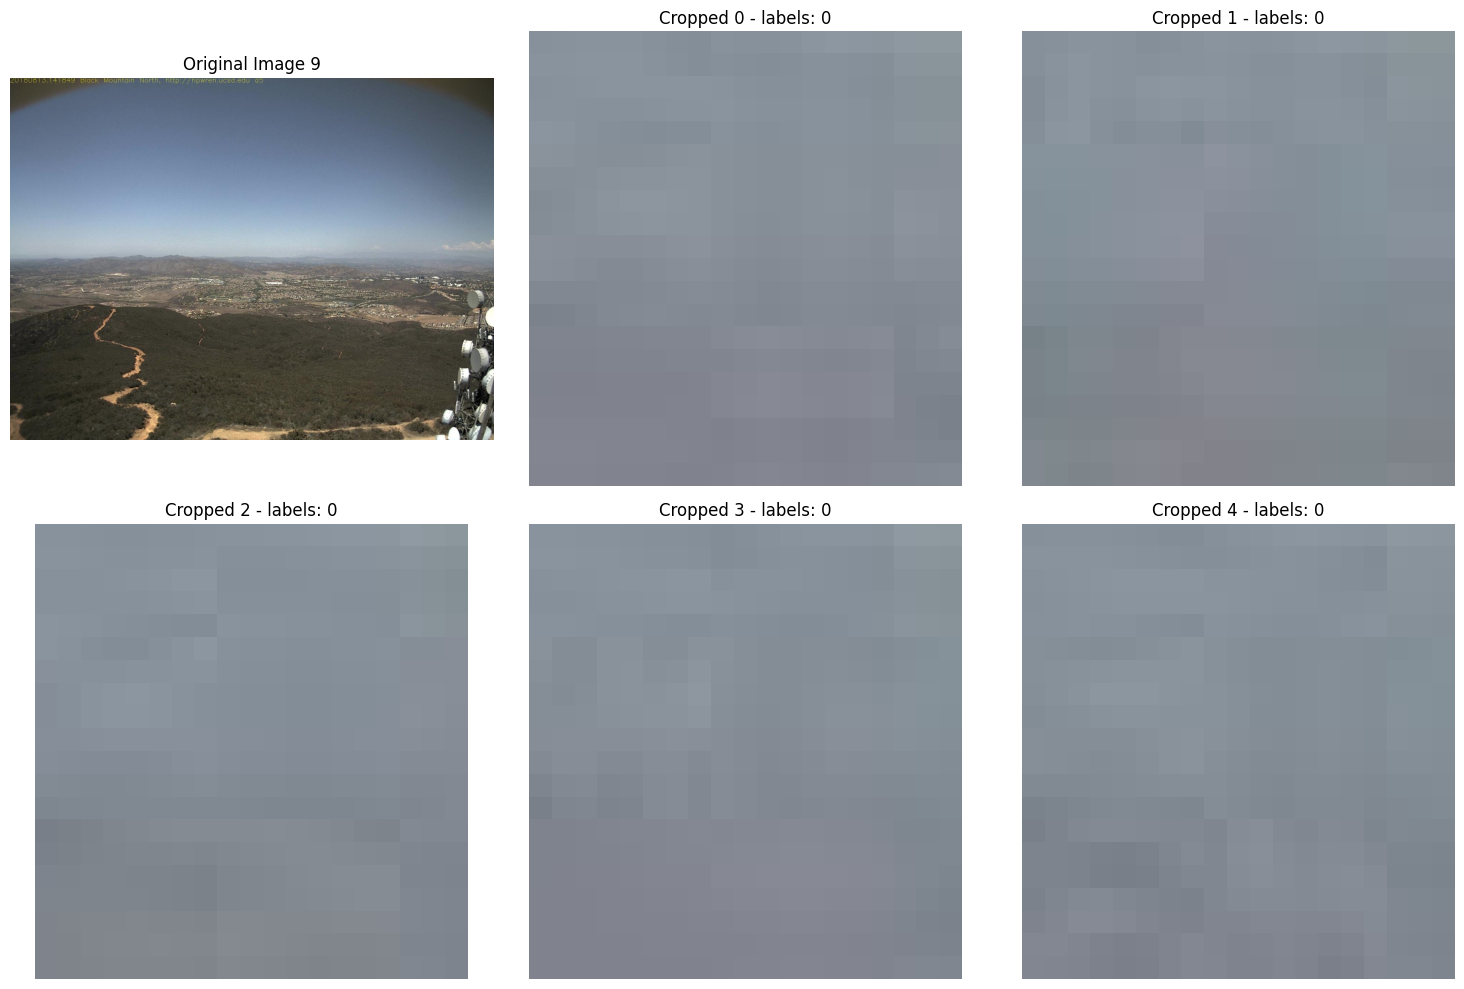

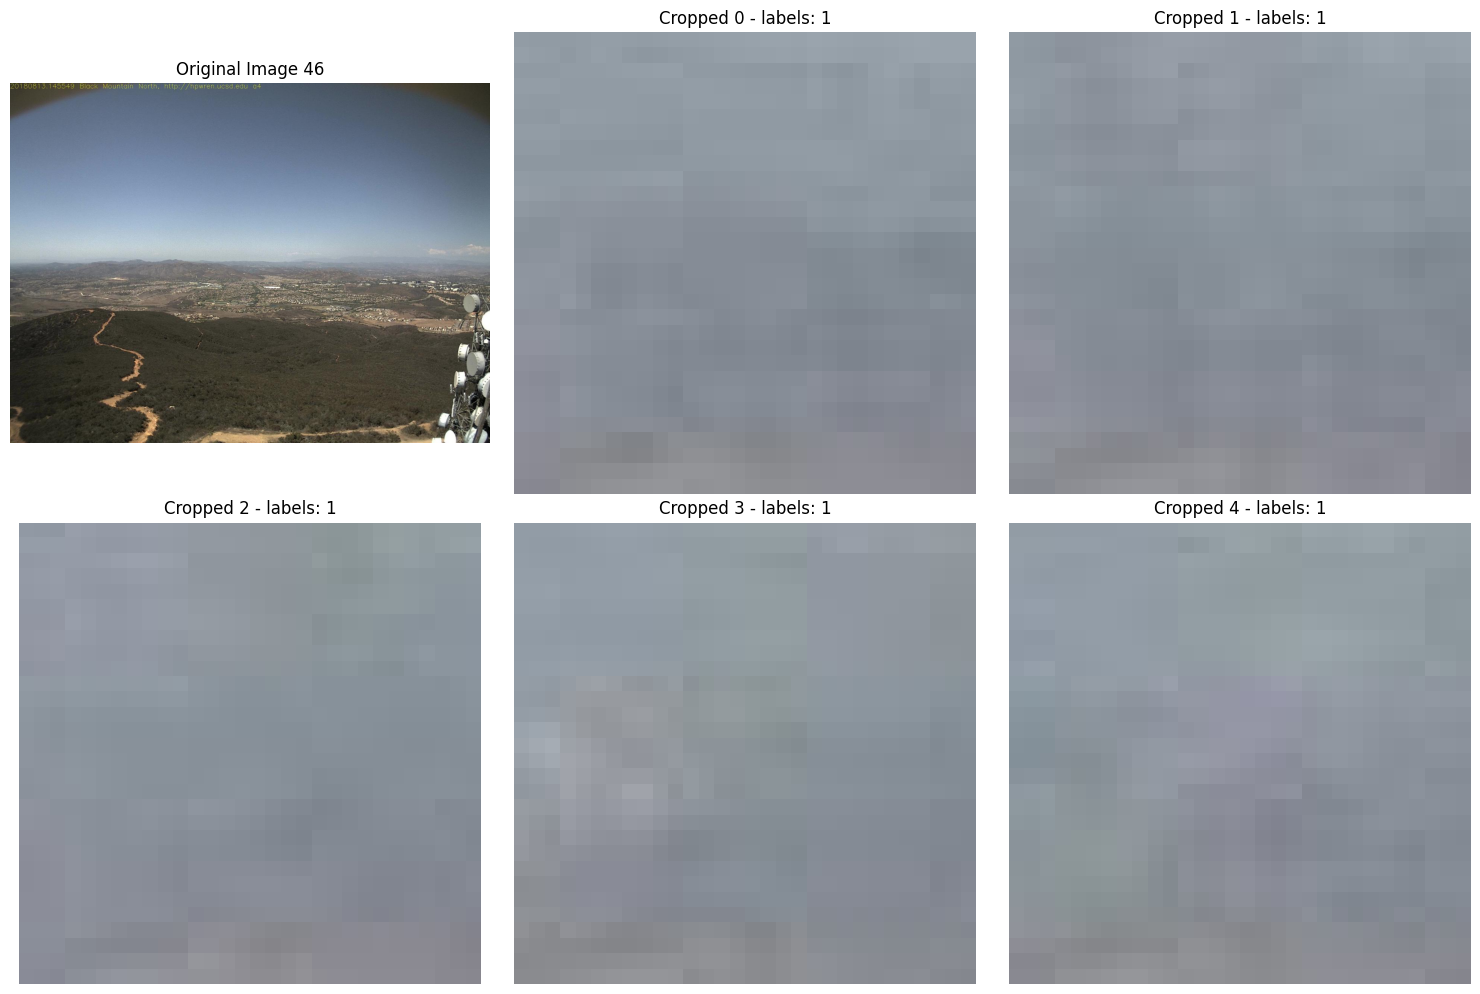

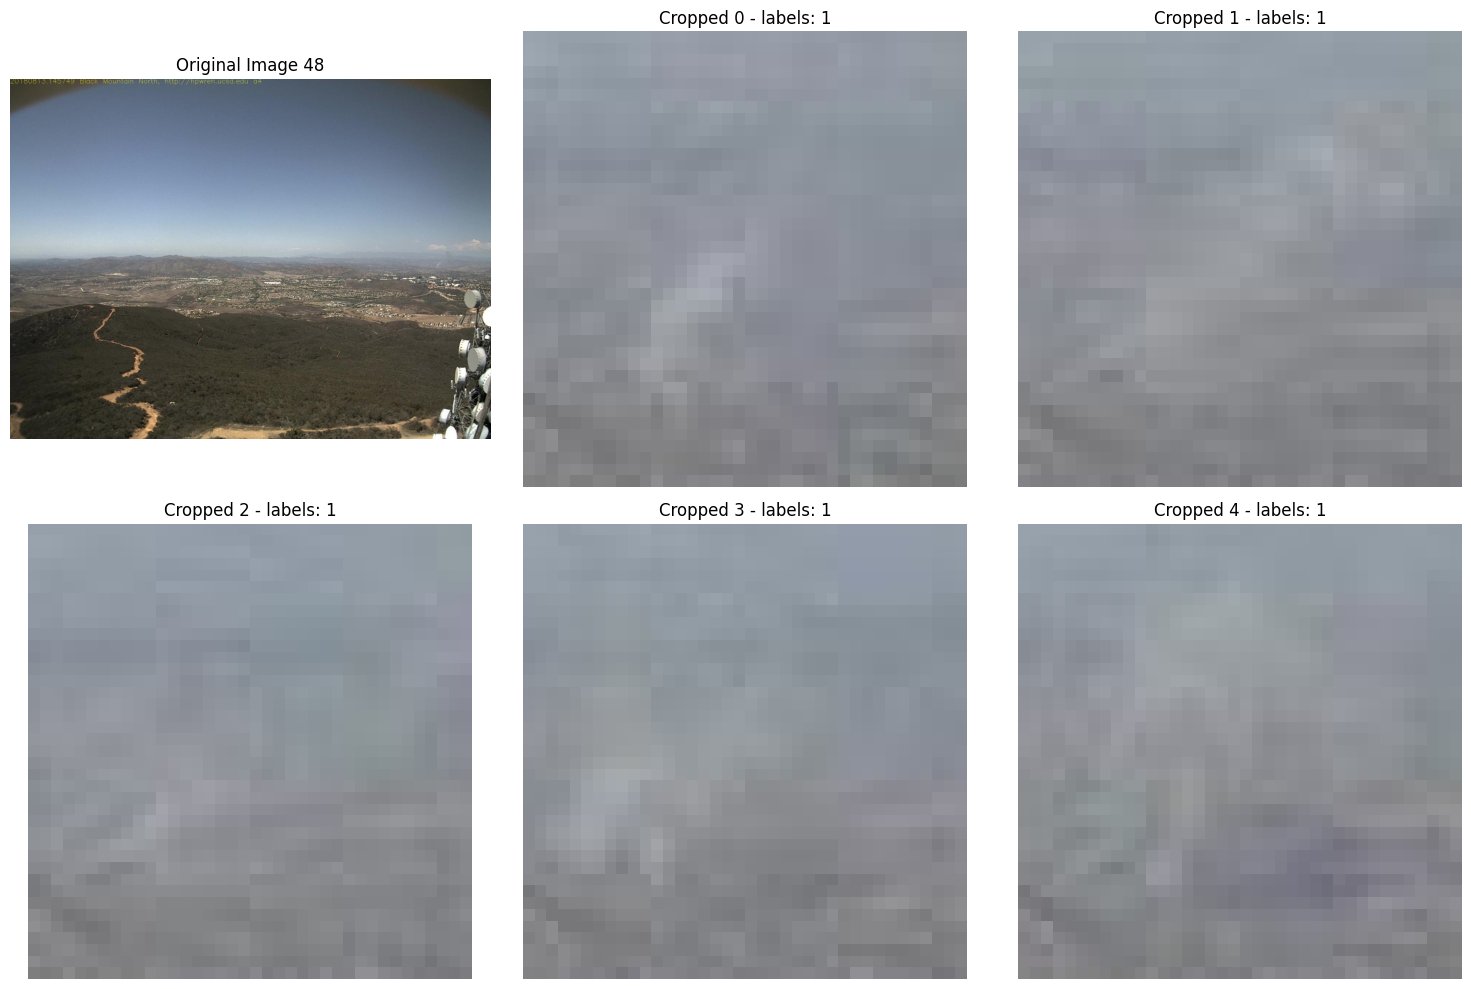

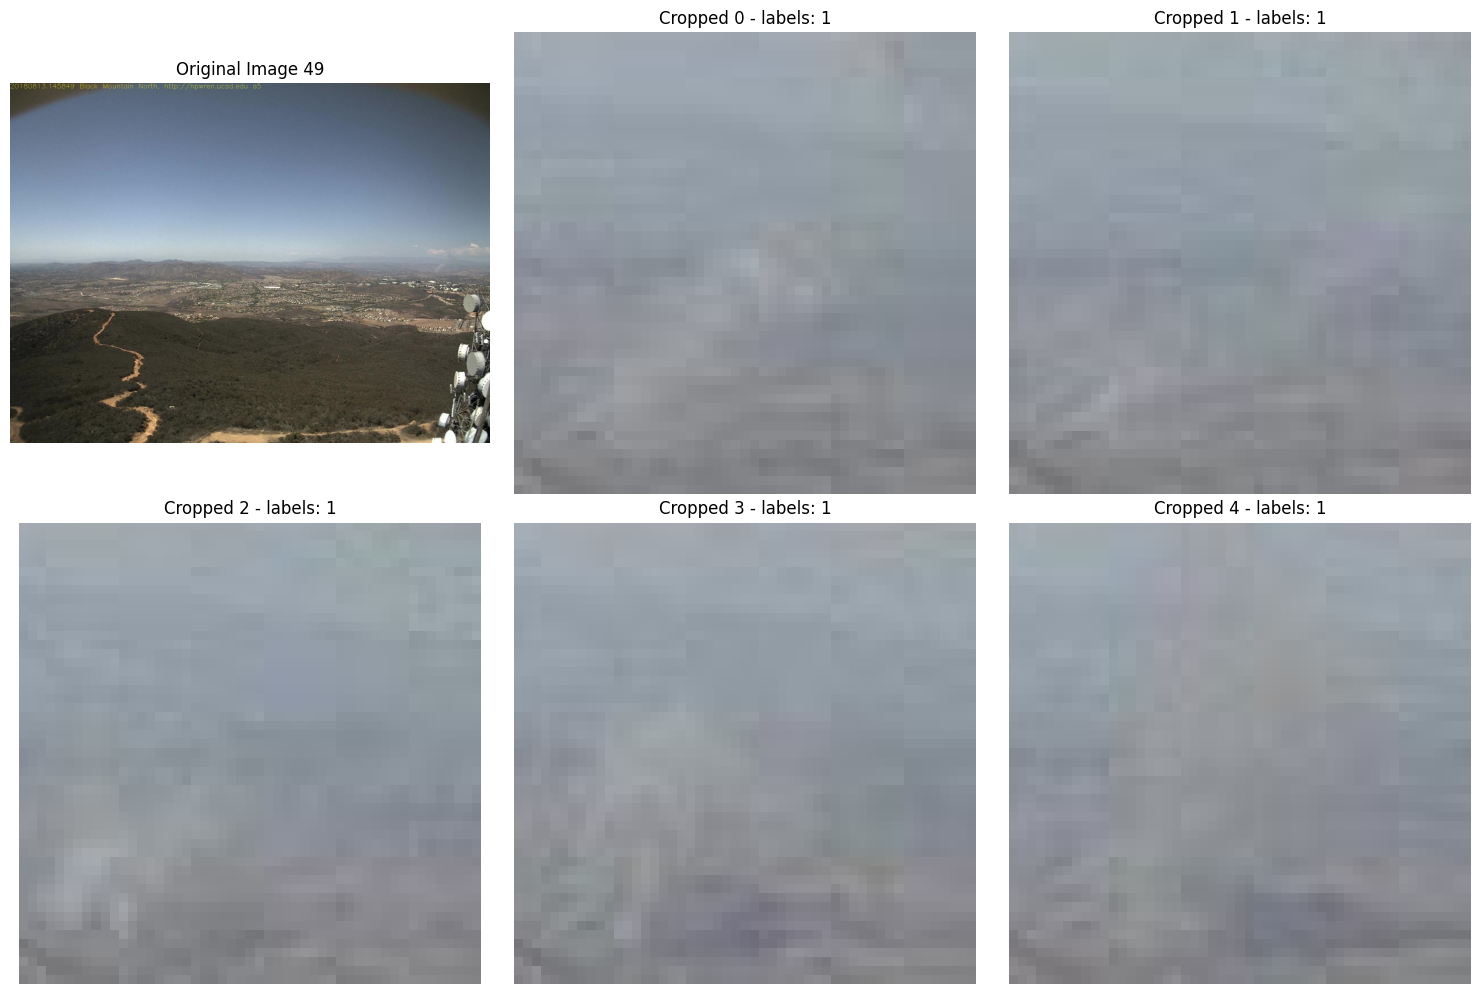

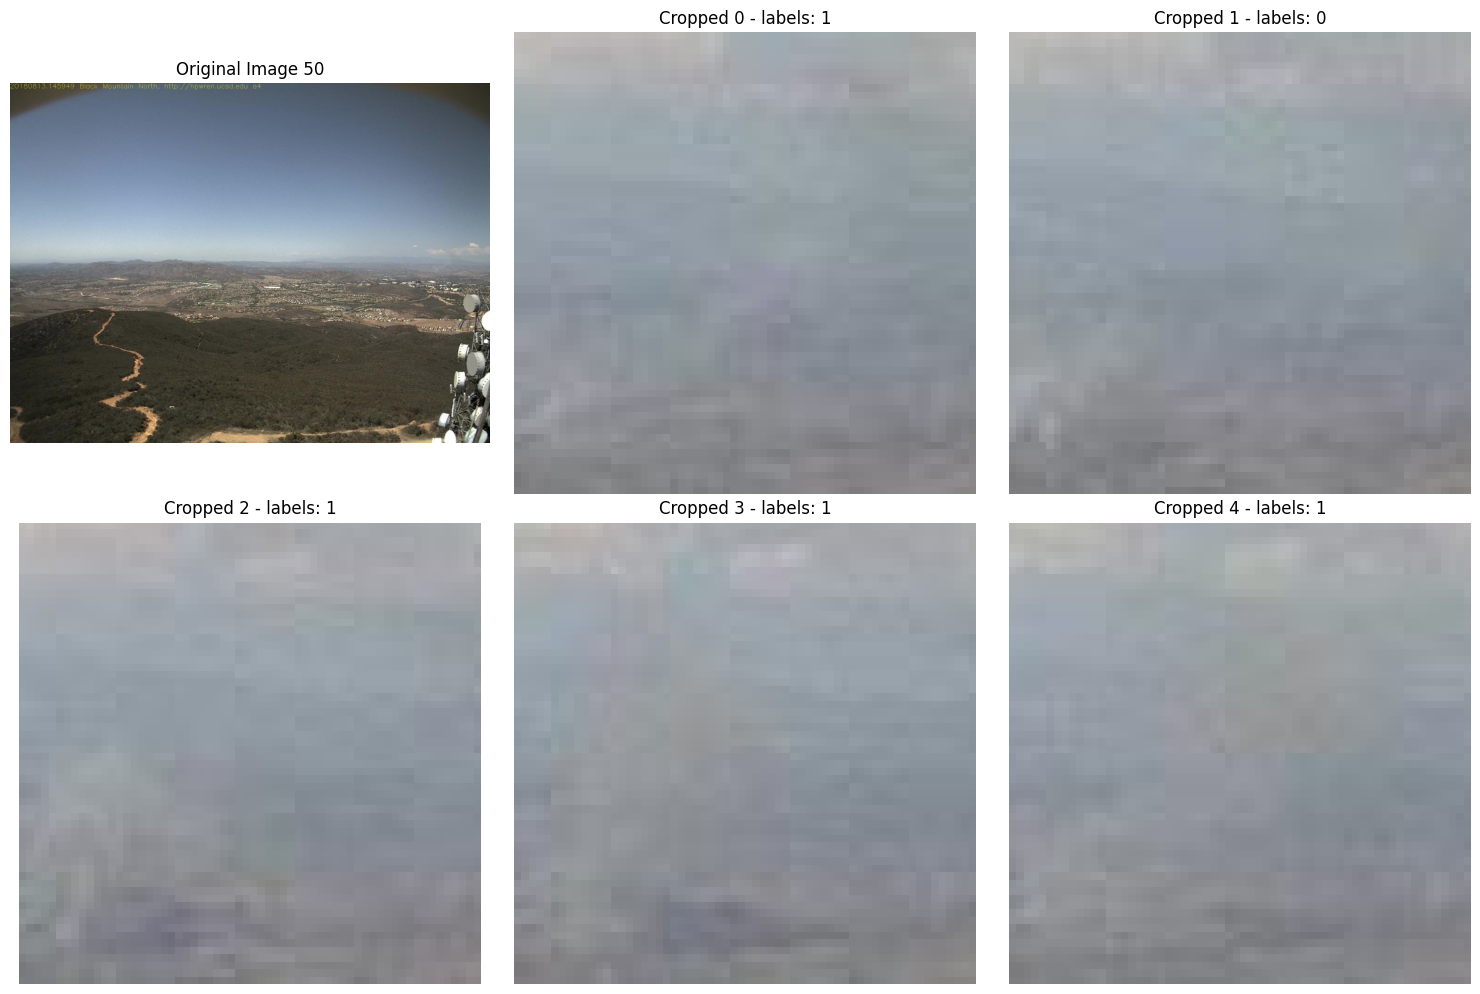

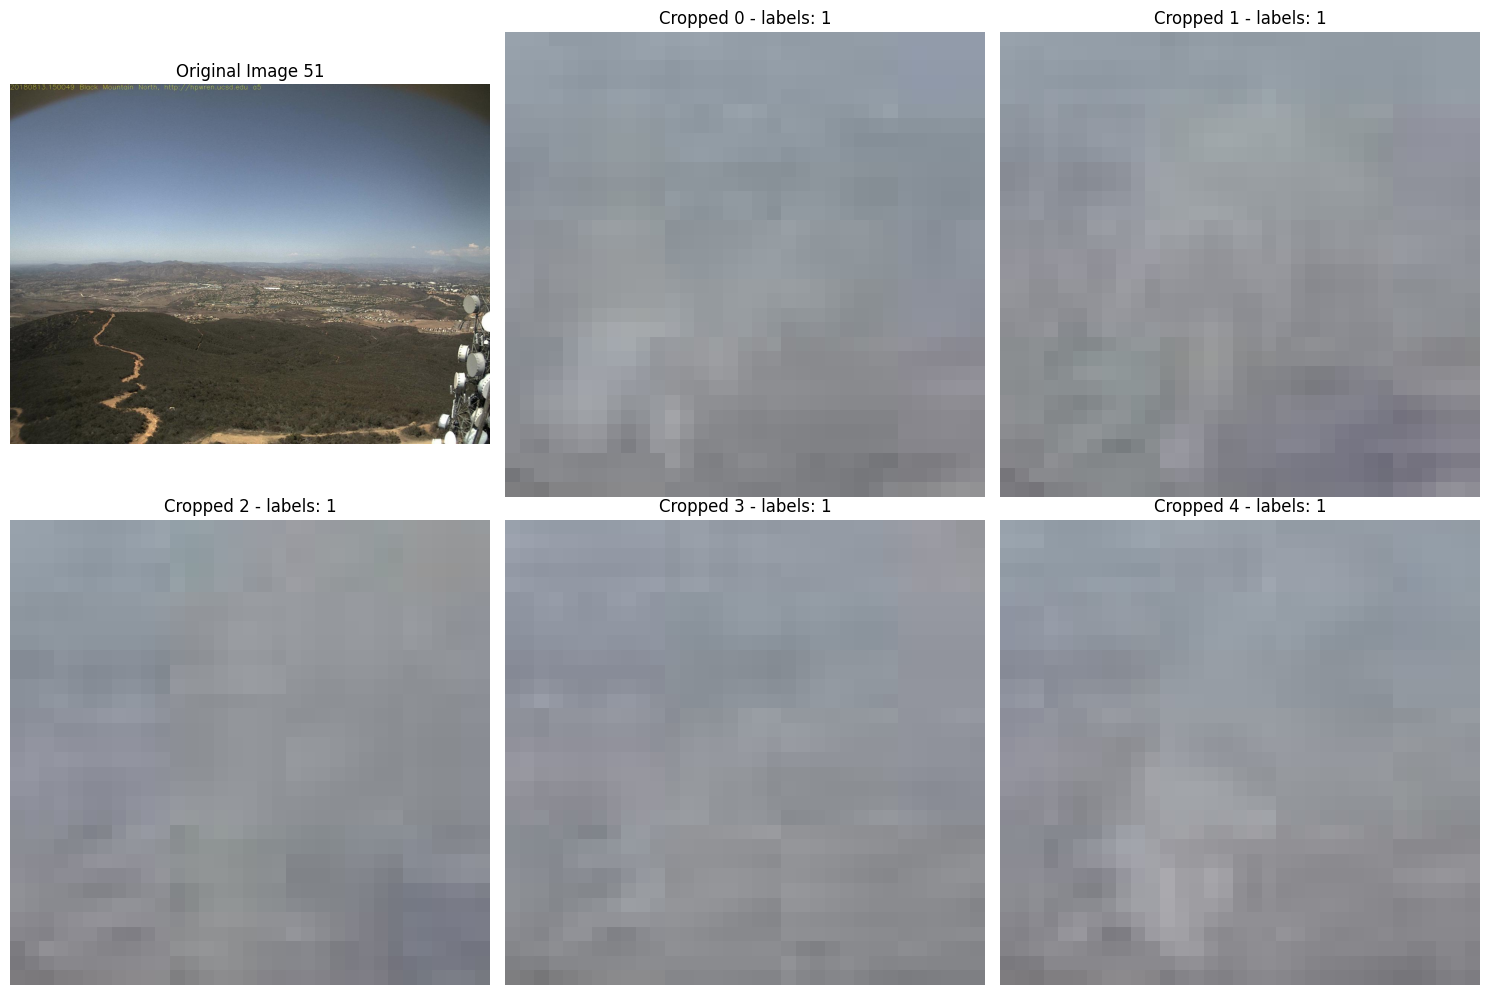

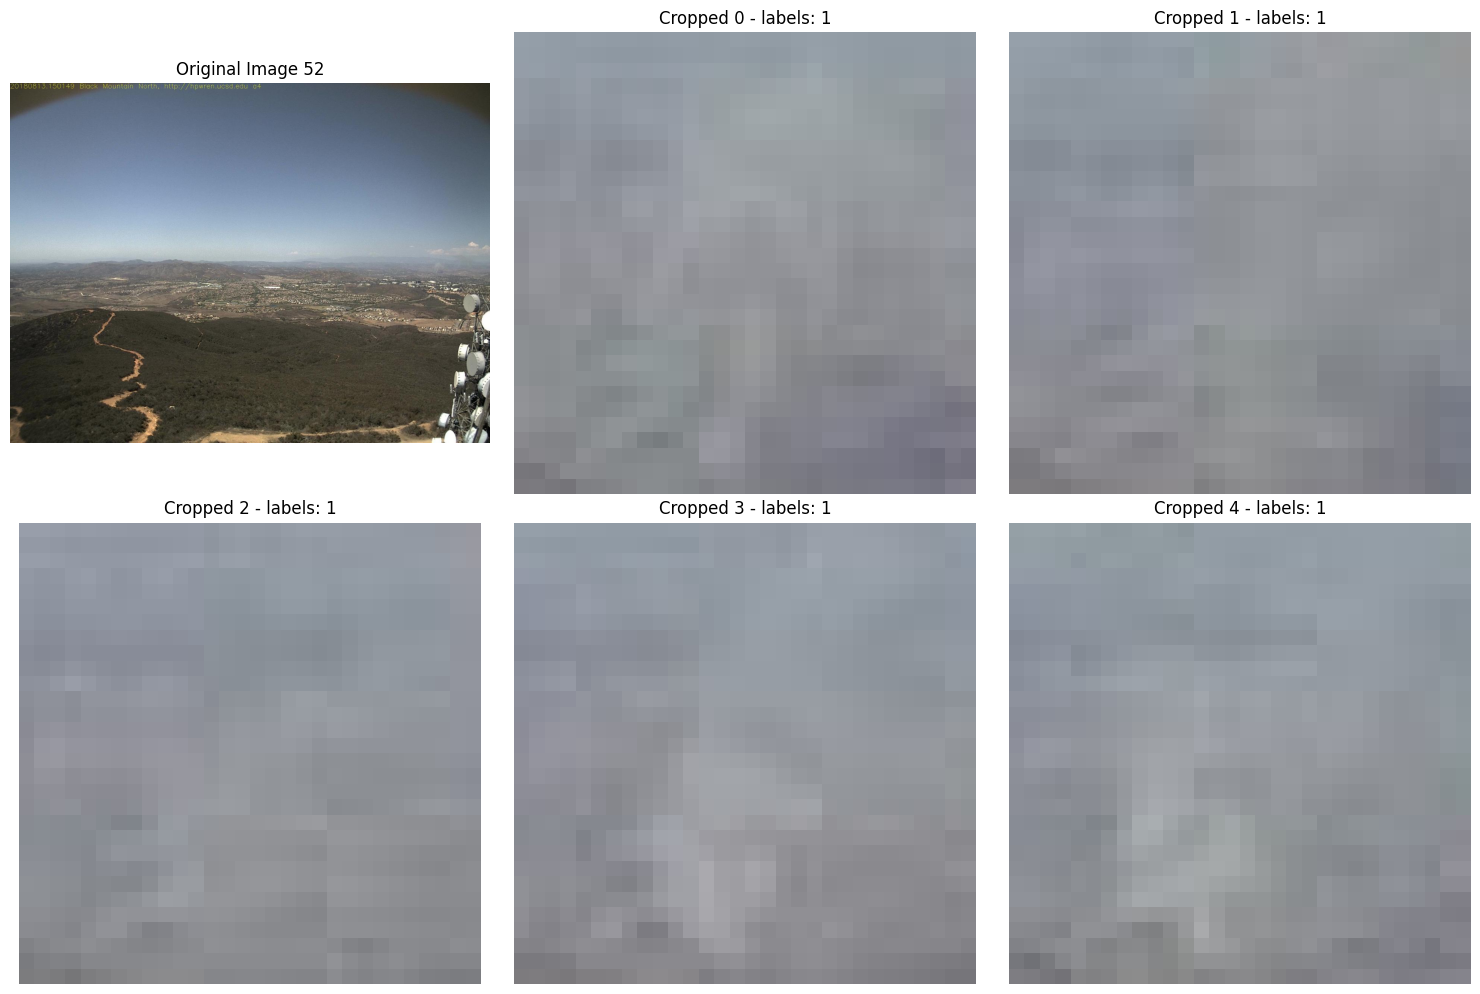

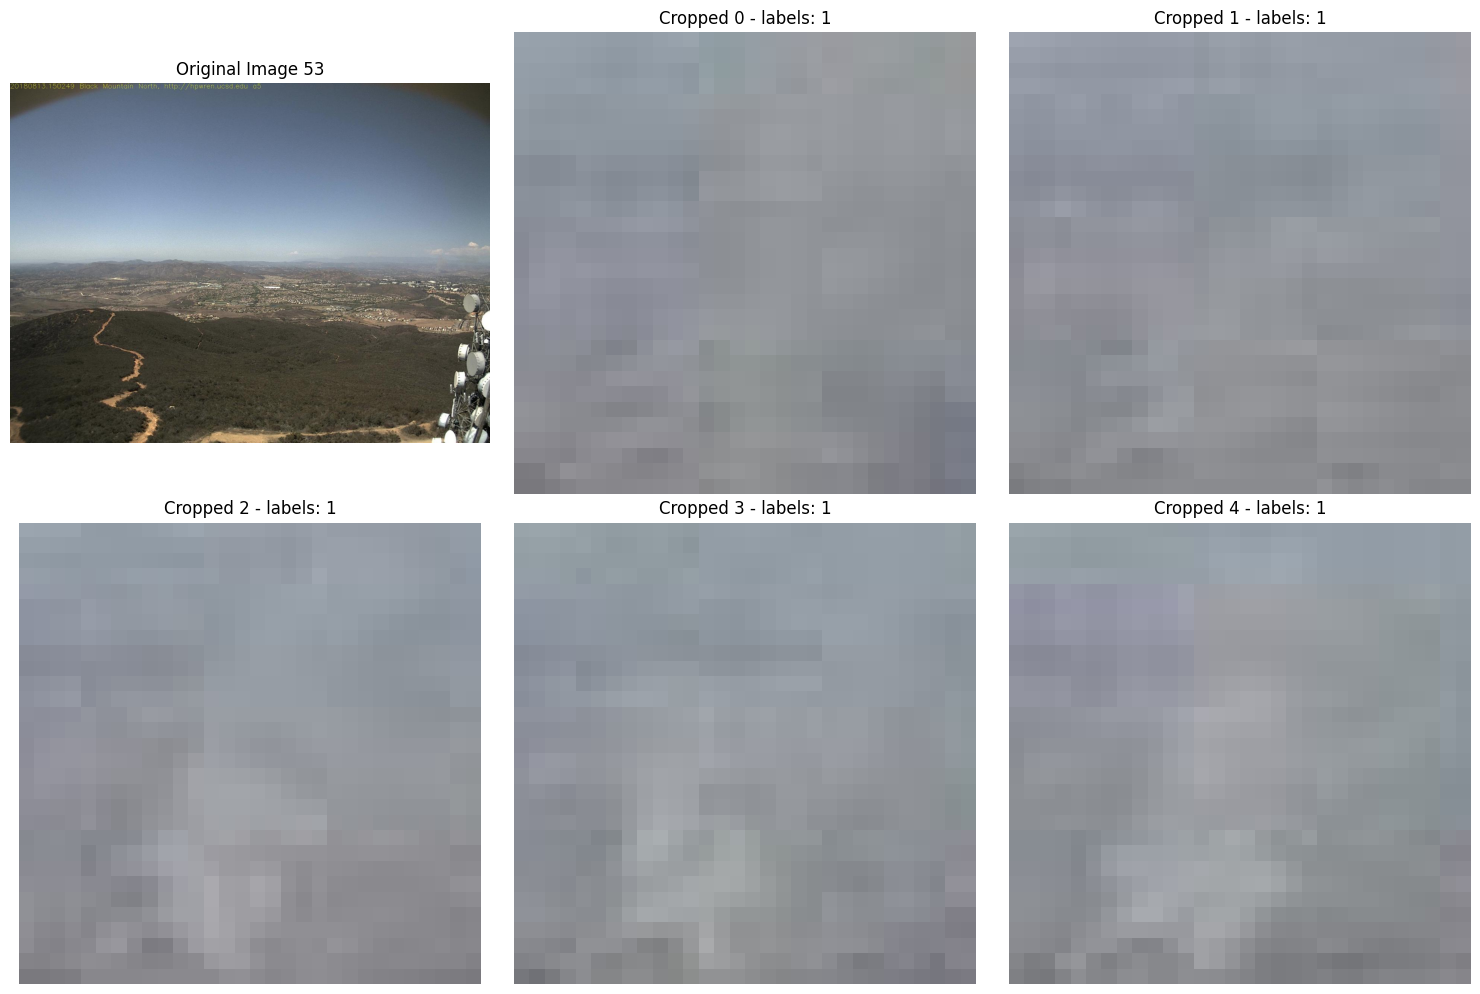

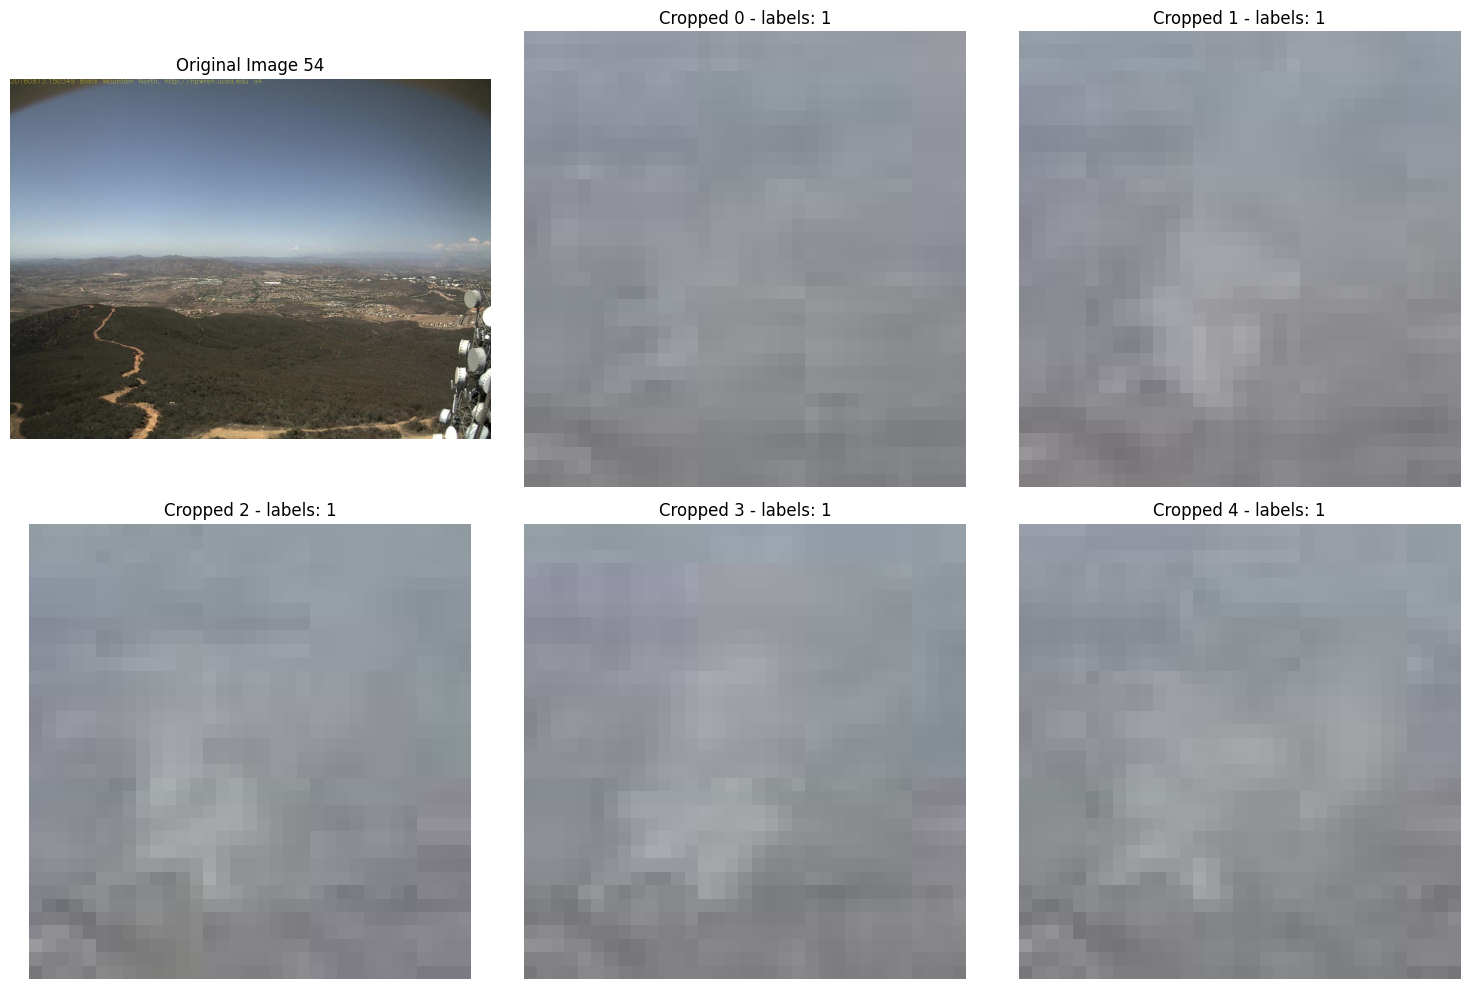

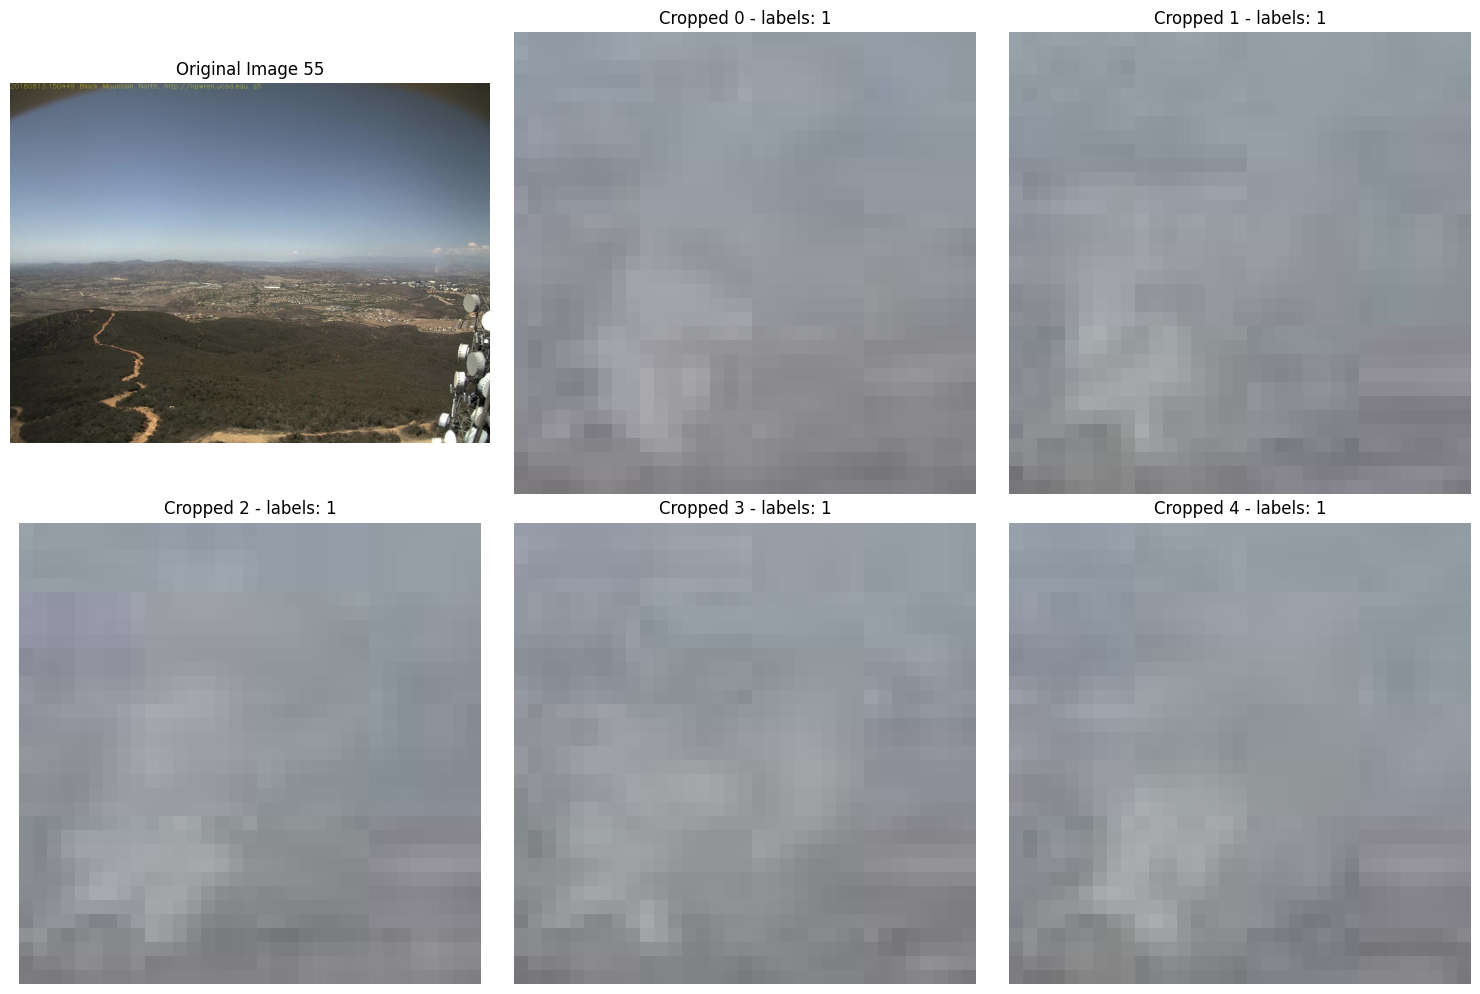

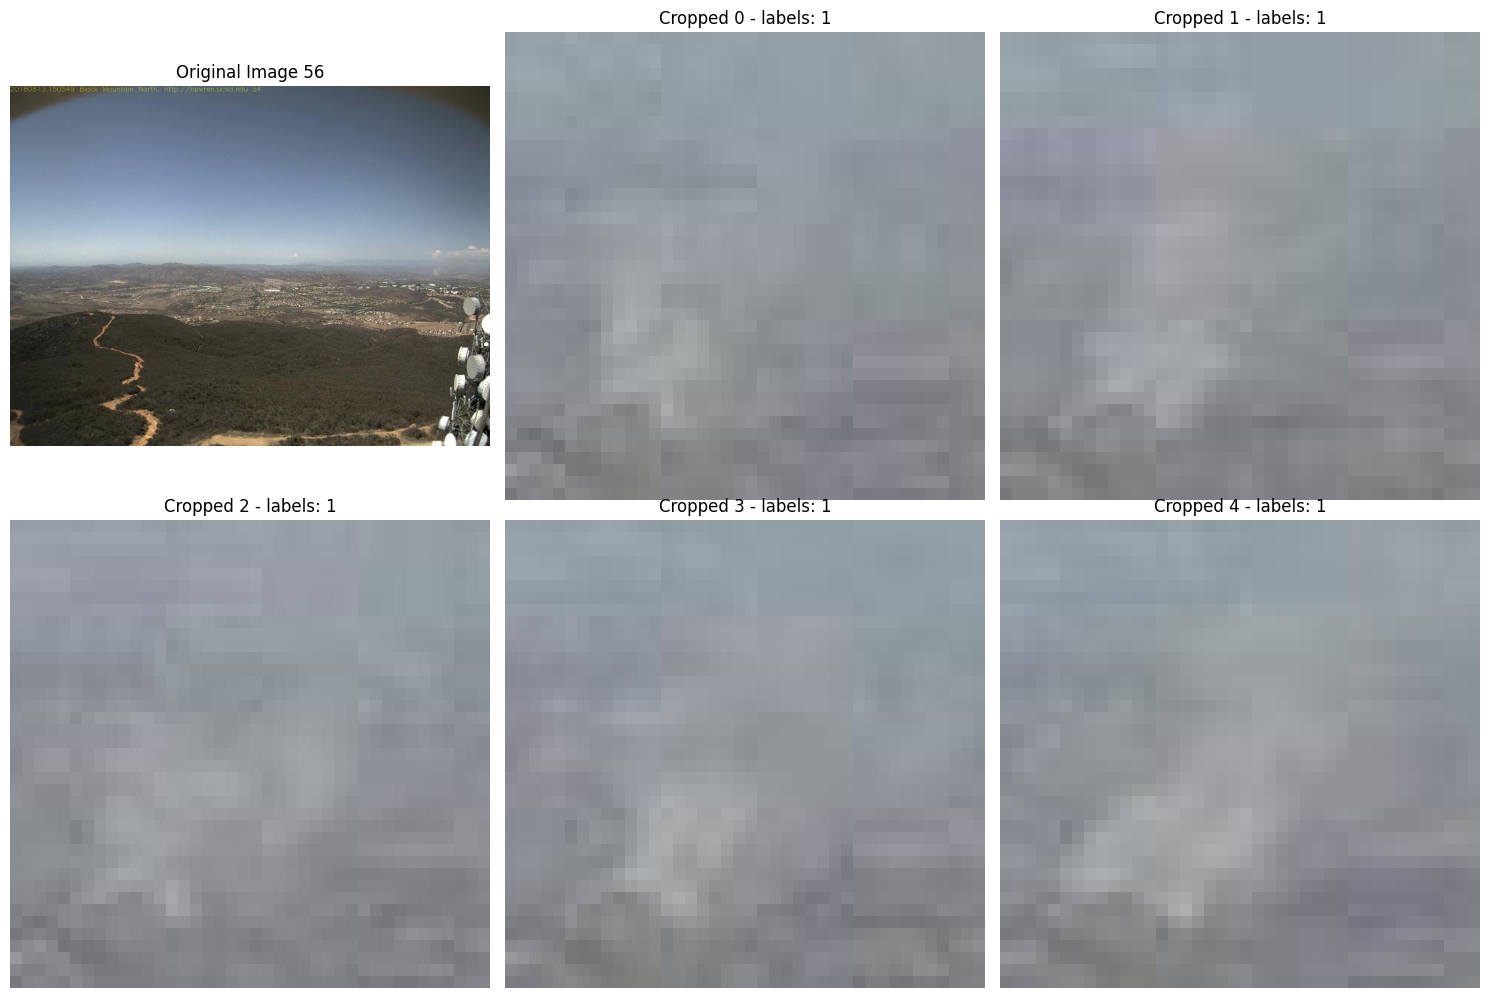

: 

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def make_square_chop(y1, y2, x1, x2, img_height=640, img_width=640, growth_factor=1.2):
    center_y = (y1 + y2) / 2
    center_x = (x1 + x2) / 2
    half_size = max((y2 - y1), (x2 - x1)) / 2 * growth_factor

    half_size = min(half_size, center_y, img_height - center_y, center_x, img_width - center_x)
    new_y1 = max(0, int(center_y - half_size))
    new_y2 = min(img_height, int(center_y + half_size))
    new_x1 = max(0, int(center_x - half_size))
    new_x2 = min(img_width, int(center_x + half_size))

    return new_y1, new_y2, new_x1, new_x2
ejemplo_0 = 10
ejemplo_1 = 10

# Procesar los videos y las imágenes
for video in data["video"].unique():
    print(video)
    frames = os.listdir(dataset_path + "/" + video)
    frames.sort()
    dff = data[data["video"] == video]
    
    # Recorrer fila por fila
    for _, row in dff.iterrows():
        frame = row["frame"]
        box = row["box"]  
        id = row["idx_frame"]
        # cambiar del formato string a una lista de floats
        box = list(map(float, box[1:-1].split(", ")))
                   
        iou = row["iou"]
        labels = [row["t_4"], row["t_3"], row["t_2"], row["t_1"], row["t_0"]]
        
        # Encontrar la posición del frame actual en la lista de frames
        try:
            current_index = frames.index(frame)
        except ValueError:
            print(f"Frame {frame} no encontrado en la lista de frames para el video {video}.")
            continue
        
        # Crear un buffer con los 4 frames anteriores más el actual
        buffer = []
        for i in range(4, -1, -1):  # Desde el frame actual hasta 4 frames atrás
            frame_index = current_index - i
            if frame_index < 0 or frame_index >= len(frames):  # Índice inválido
                buffer.append(-1)
            else:
                buffer.append(frames[frame_index])
        
        # Leer los frames del buffer y cortarlos por el box
        cropped_images = []
        original_image = None
        for i, frame_name in enumerate(buffer):
            if frame_name == -1:  # Frame no disponible, crear imagen vacía
                cropped_images.append(np.zeros((640, 640, 3), dtype=np.uint8))
            else:
                # Cargar la imagen
                img = cv2.imread(dataset_path + "/" + video + "/" + frame_name)
                if img is None:  # Validar que la imagen exista
                    print(f"Error al cargar la imagen {frame_name}")
                    cropped_images.append(np.zeros((640, 640, 3), dtype=np.uint8))
                else:
                    if original_image is None:
                        original_image = img  # Guardar la imagen original para el plot
                    img_height, img_width, _ = img.shape
                    # Convertir el box de formato normalizado a absoluto
                    x1, y1, x2, y2 = box
                    x1 = int(x1 * img_width)
                    x2 = int(x2 * img_width)
                    y1 = int(y1 * img_height)
                    y2 = int(y2 * img_height)
                    
                    # Obtener coordenadas cuadradas ajustadas
                    new_y1, new_y2, new_x1, new_x2 = make_square_chop(
                        y1, y2, x1, x2, img_height=img_height, img_width=img_width
                    )
                    
                    # Cortar la imagen
                    cropped_images.append(img[new_y1:new_y2, new_x1:new_x2])

    
        # Graficar la imagen original y los recortes
        if ejemplo_0 == 0 and labels[0] == 0:
            continue
        if ejemplo_1 == 0 and labels[0] == 1:
            continue
        plt.figure(figsize=(15, 10))
        
        # Mostrar la imagen original
        plt.subplot(2, 3, 1)
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image {id}")
        plt.axis("off")
        
        # Mostrar los recortes
        for i, cropped_img in enumerate(cropped_images):
            plt.subplot(2, 3, i + 2)
            plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Cropped {i} - labels: {labels[i]}")
            plt.axis("off")
        
        plt.tight_layout()
        plt.show()
        if labels[0] == 1:
            ejemplo_1 -= 1
        else:
            ejemplo_0 -= 1
        if ejemplo_0 == 0 and ejemplo_1 == 0:
            break

        
    break
        # Break después de un ejemplo
    





        
    
       



In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import os
import cv2
import numpy as np
from tqdm import tqdm

# Clase para la extracción de características
class ImageFeatureExtractor(nn.Module):
    def __init__(self, model_name='resnet50', pretrained=True, output_features=256):
        super(ImageFeatureExtractor, self).__init__()

        if model_name == 'resnet50':
            self.feature_extractor = models.resnet50(pretrained=pretrained)
            self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-1]).to(device)
            feature_dim = 2048

        elif model_name == 'efficientnet_b0':
            self.feature_extractor = models.efficientnet_b4(pretrained=pretrained)
            self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-1]).to(device)
            feature_dim = 1792

        else:
            raise ValueError(f"Modelo '{model_name}' no soportado.")

        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        self.fc = nn.Linear(feature_dim, output_features)

    def forward(self, x):
        batch_size, sequence_length, C, H, W = x.size()
        x = x.view(batch_size * sequence_length, C, H, W)

        features = self.feature_extractor(x.to(device))
        features = torch.flatten(features, 1)
        out = features.view(batch_size, sequence_length, -1)
        return out.to('cpu')

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Instancia del extractor de características
extractor = ImageFeatureExtractor(model_name='resnet50', pretrained=True, output_features=256).to(device)

# Listas para almacenar características y etiquetas
features_list = []
labels_list = []

# Procesar videos y extraer características
for video in tqdm(data["video"].unique()):
    print(f"Procesando video: {video}")
    frames = os.listdir(dataset_path + "/" + video)
    frames.sort()
    dff = data[data["video"] == video]
    
    for _, row in dff.iterrows():
        frame = row["frame"]
        box = row["box"]  # Formato [x1, y1, x2, y2]
        labels = [row["t_4"], row["t_3"], row["t_2"], row["t_1"], row["t_0"]]
        
        # Encontrar la posición del frame actual en la lista de frames
        try:
            current_index = frames.index(frame)
        except ValueError:
            print(f"Frame {frame} no encontrado en la lista de frames para el video {video}.")
            continue
        
        # Crear un buffer con los 4 frames anteriores más el actual
        buffer = []
        for i in range(4, -1, -1):  # Desde el frame actual hasta 4 frames atrás
            frame_index = current_index - i
            if frame_index < 0 or frame_index >= len(frames):  # Índice inválido
                buffer.append(np.zeros((640, 640, 3), dtype=np.uint8))  # Imagen vacía
            else:
                img = cv2.imread(dataset_path + "/" + video + "/" + frames[frame_index])
                if img is None:
                    buffer.append(np.zeros((640, 640, 3), dtype=np.uint8))
                else:
                    img_height, img_width, _ = img.shape
                    x1, y1, x2, y2 = box
                    x1 = int(x1 * img_width)
                    x2 = int(x2 * img_width)
                    y1 = int(y1 * img_height)
                    y2 = int(y2 * img_height)
                    cropped_img = img[y1:y2, x1:x2]
                    buffer.append(cropped_img)

        # Transformar las imágenes del buffer
        buffer = [transform(img) for img in buffer]
        buffer = torch.stack(buffer).unsqueeze(0).to(device)  # Batch x Sequence x C x H x W

        # Extraer características
        with torch.no_grad():
            features = extractor(buffer)

        # Guardar características y etiquetas
        features_list.append(features.squeeze(0))  # Sin batch dimension
        labels_list.append(torch.tensor(labels))

# Convertir listas a tensores
features_tensor = torch.stack(features_list)  # Tensor de características
labels_tensor = torch.stack(labels_list)     # Tensor de etiquetas

# Guardar en archivo binario
output_path_features = "features.pt"
output_path_labels = "labels.pt"
torch.save(features_tensor, output_path_features)
torch.save(labels_tensor, output_path_labels)

print(f"Características guardadas en: {output_path_features}")
print(f"Etiquetas guardadas en: {output_path_labels}")
